In [1]:
from google.colab import drive
drive.mount('/content/drive/')

!git clone https://github.com/realcrane/iPLAN-Interactive-and-Procedural-Layout-Planning

import os
print("Directory di lavoro corrente:", os.getcwd())
roomType_directory = '/content/iPLAN-Interactive-and-Procedural-Layout-Planning/'
os.chdir(roomType_directory)
print("Nuova directory di lavoro:", os.getcwd())

Mounted at /content/drive/
Cloning into 'iPLAN-Interactive-and-Procedural-Layout-Planning'...
remote: Enumerating objects: 301, done.
remote: Counting objects: 100% (210/210), done.
remote: Compressing objects: 100% (156/156), done.
remote: Total 301 (delta 96), reused 106 (delta 46), pack-reused 91
Receiving objects: 100% (301/301), 12.98 MiB | 28.46 MiB/s, done.
Resolving deltas: 100% (117/117), done.
Directory di lavoro corrente: /content
Nuova directory di lavoro: /content/iPLAN-Interactive-and-Procedural-Layout-Planning


In [2]:
import os
import torch
import numpy as np
import scipy.io as sio

In [3]:
def fine_turning(pred_rBoxes, boundary, living_mask, criterion, opt):
  lr = opt.lr
  pred_rBoxes = torch.autograd.Variable(pred_rBoxes, requires_grad=True)
  loss = criterion(pred_rBoxes, boundary, living_mask, opt)
  loss.backward()
  grad = pred_rBoxes.grad
  pred_rBoxes = pred_rBoxes - lr * grad
  return pred_rBoxes

def get_ratio(layout):
  spare_area = (layout == 16).sum()
  inside_area = (layout < 13).sum() + spare_area
  ratio = spare_area / inside_area
  return ratio

def obtain_living(layout, boundary):
  living_mask = layout.clone()
  living_mask[living_mask < 16] = 0
  min_y, min_x = np.min(boundary[:, :2], 0)
  max_y, max_x = np.max(boundary[:, :2], 0)
  for h in range(int(min_x) - 5, int(max_x) + 5):
    for w in range(int(min_y) - 5, int(max_y) + 5):
      if living_mask[h, w] == 0 and living_mask[h + 1, w] == 16 and living_mask[h + 2, w] == 0:
        living_mask[h + 1, w] = 0
      elif living_mask[h, w] == 0 and living_mask[h + 1, w] == 16 and living_mask[h + 2, w] == 16 and living_mask[
        h + 3, w] == 0:
        living_mask[h + 1, w] = 0
        living_mask[h + 2, w] = 0
      elif living_mask[h, w] == 0 and living_mask[h + 1, w] == 16 and living_mask[h + 2, w] == 16 and living_mask[
        h + 3, w] == 16 and living_mask[h + 4, w] == 0:
        living_mask[h + 1, w] = 0
        living_mask[h + 2, w] = 0
        living_mask[h + 3, w] = 0

      if living_mask[h, w] == 0 and living_mask[h, w + 1] == 16 and living_mask[h, w + 2] == 0:
        living_mask[h, w + 1] = 0
      elif living_mask[h, w] == 0 and living_mask[h, w + 1] == 16 and living_mask[h, w + 2] == 16 and living_mask[
        h, w + 3] == 0:
        living_mask[h, w + 1] = 0
        living_mask[h, w + 2] = 0
      elif living_mask[h, w] == 0 and living_mask[h, w + 1] == 16 and living_mask[h, w + 2] == 16 and living_mask[
        h, w + 3] == 16 and living_mask[h, w + 4] == 0:
        living_mask[h, w + 1] = 0
        living_mask[h, w + 2] = 0
        living_mask[h, w + 3] = 0
  layout[living_mask==16]=0
  index = torch.where(living_mask)
  min_x, max_x = torch.min(index[0]),torch.max(index[0])
  min_y, max_y = torch.min(index[1]), torch.max(index[1])
  box = torch.stack([min_y, min_x, max_y, max_x]) / 127
  return box, layout, living_mask/16

def get_image(img, rBoxes, rTypes, inside, living_mask=None):
  if not living_mask==None:
    img[living_mask==1]=0
  for r_i in range(len(rTypes)):
    r_box = rBoxes[r_i, :] * 127
    r_box = r_box.long()
    r_type = rTypes[r_i]
    mask = torch.zeros(inside.size())
    mask[r_box[1]:r_box[3] + 1, r_box[0]:r_box[2] + 1] = 1
    mask = mask * inside
    img = img * (1 - mask) + mask * r_type
  return img

# Modifica

Si aggiunge manualemte delle cordinate per far si che si superi l'if, aggiunta di rTypes

In [4]:
def getList(path):
    mat_list = os.listdir(path)
    mat_list.sort()
    temp_list = []
    for name in mat_list[:]:
      mat_path = os.path.join(path, name)
      data = sio.loadmat(mat_path, squeeze_me=True, struct_as_record=False)['data']
      data.rTypes = 1
      if name == "0.mat":
        center = []
        center.append([58,71])
        data.rCenters = center
      else:
        center = []
        center.append([64,69])
        data.rCenters = center
      if len(data.rBoxes) == 0 and len(data.rCenters) !=0:
          temp_list.append(name)
    return temp_list

In [5]:
import sys
sys.path.append('/content/iPLAN-Interactive-and-Procedural-Layout-Planning/room_partition')
sys.path.append('/content/iPLAN-Interactive-and-Procedural-Layout-Planning/room_partition/models')

In [6]:
from synth.floorplan.roompartition_fp import FloorPlan
from room_partition.utils import colorize_mask
from room_partition import models
import argparse

Tra gli errori degli sviluppatori c'è la non possibilità di instanziare LossFun per ovviare a questo problema e per non stravolgere la sintassi del codice con aggiunta di file __init__.py la cartelaa vine spostata in

In [7]:
import shutil


cartella_origine = '/content/iPLAN-Interactive-and-Procedural-Layout-Planning/room_partition/utils'
cartella_destinazione = '/content/iPLAN-Interactive-and-Procedural-Layout-Planning/room_partition/models'

shutil.move(cartella_origine, cartella_destinazione)


'/content/iPLAN-Interactive-and-Procedural-Layout-Planning/room_partition/models/utils'

In [8]:
from room_partition.models.loss_layer import LossFun

#Modifica Input

Per permettere il funzionamento del codice su google colab l'instanzazione di colab nel seguente modo:

    parser = argparse.ArgumentParser()
    parser.add_argument('--load_netG_path', type=str, default='/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/Progetto/Model/room_partition/G_net_210.pth',
                        help='path of net G')
    parser.add_argument('--max_iter', type=int, default=200, help='maximum of iteration')
    parser.add_argument('--gpu_ids', nargs='+', type=int, default=[0], help='id of GPU')
    parser.add_argument('--lr', type=float, default=10)
    parser.add_argument('--coverage', type=float, default=1)
    parser.add_argument('--inside', type=float, default=0.5)
    parser.add_argument('--mutex', type=float, default=0)
    parser.add_argument('--root', type=str, default='/content/iPLAN-Interactive-and-Procedural-Layout-Planning/data', help='id of GPU')
    opt = parser.parse_args()

Viene modificata in

    opt = {
      'load_netG_path': '/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/Progetto/Model/room_partition/G_net_210.pth',
      'max_iter': 200,
      'gpu_ids': [0],
      'lr': 10,
      'coverage': 1,
      'inside': 0.5,
      'mutex': 0,
      'root': '/content/iPLAN-Interactive-and-Procedural-Layout-Planning/data'
    }


Utilizzando un dizionario il codice non funziona poichè bisognerebbe cambiare il codice dei modelli perchè per accedere ad un elemento nel dizionario bisogna inserire la chiave mentre nel codice si considerano le chiavi come attributi di un oggeto. Per ovviare a questo problema si definisce la clsse **AttrDict**.
    
    class AttrDict(dict):
    """Classe wrapper per consentire l'accesso attributivo agli elementi del dizionario."""

    def __getattr__(self, name):
        return self[name]

    def __setattr__(self, name, value):
        self[name] = value

e il dizionario si instanzia nel seguente modo:

    opt = AttrDict({
      'load_netG_path': '/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/Progetto/Model/room_partition/G_net_210.pth',
      'max_iter': 200,
      'gpu_ids': [0],
      'lr': 10,
      'coverage': 1,
      'inside': 0.5,
      'mutex': 0,
      'root': '/content/iPLAN-Interactive-and-Procedural-Layout-Planning/data'
    })

In modo da poter acceder ad ogni chiave come un attriburo, es opt.gpu_ids invece di opt['gpu_ids']

In [9]:
class AttrDict(dict):
    """Classe wrapper per consentire l'accesso attributivo agli elementi del dizionario."""

    def __getattr__(self, name):
        return self[name]

    def __setattr__(self, name, value):
        self[name] = value

In [10]:
opt = AttrDict({
    'load_netG_path': '/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/Progetto/Model/room_partition/G_net_210.pth',
    'max_iter': 200,
    'gpu_ids': [0],
    'lr': 10,
    'coverage': 1,
    'inside': 0.5,
    'mutex': 0,
    'root': '/content/iPLAN-Interactive-and-Procedural-Layout-Planning/data'
})

#Modifiche
Nel codice originale

    fp_rnn = models.FloorPlanRNNTest(opt)

Ma la classe ***FloorPlanRNNTest*** non esiste per cui si usa:

    fp_rnn = FloorPlanRNN(opt)
Dove ***FloorPlanRNN*** è preso da models.floorplan_rnn_test

# Ulteriore problema
FloorPlannRNN al suo interno istanzia due modeeli uno dei quali **RenderNet** usa variabile locale che sta per un path a un file **.pkl**. Per questo motivo si deve cambiare il codice manualmente. \\
Il codice da modificare si trova in ***room_partition/models/net.py***. \\
Viene modificata la riga **22** da \\
    pretrain_model = "./weights/renderer.pkl"
a nel nostro caso \\
    pretrain_model = "/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/Progetto/Model/room_partition/renderer.pkl"


Per lo stesso problema si cambia la riga **62** da \\
    pretrain_model = '../room_partition/weights/renderer.pkl'
a \\
    pretrain_model = '/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/Progetto/Model/room_partition/renderer.pkl'

In questo caso si sta modificando il path per l'istanzazione della classe **BoundingBoxNet**.



In [11]:
from models.floorplan_rnn_test import FloorPlanRNN

In [12]:
# step1: configure model
print('Building model...')
fp_rnn = FloorPlanRNN(opt)
fp_rnn.load_networks(opt)
criterion = LossFun(device=fp_rnn.device)


Building model...
load the pretrained Mask generation model


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [13]:

# step2: data
print('Building dataset...')
data_root = os.path.join(opt.root, 'test')
floorplans = getList(data_root)
print('The length of testing data is {}'.format(len(floorplans)))

Building dataset...
The length of testing data is 2


In [14]:
def getMath(path, i ):
  mat_list = os.listdir(path)
  mat_list.sort()
  temp_list = []
  for name in mat_list[:]:
    mat_path = os.path.join(path, name)
    data = sio.loadmat(mat_path, squeeze_me=True, struct_as_record=False)['data']
    data.rTypes = np.array([1])
    if name == "0.mat":
      center = []
      center.append([58,71])
      data.rCenters = np.array(center)
      if i == 0: return data
    else:
      center = []
      center.append([64,69])
      data.rCenters = np.array(center)
      if i ==1: return data


In [15]:
def get_input(data):
  img = fp.init_input_img(fp.exterior_boundary)
  h, w = img.shape
  inside = np.zeros((h, h))
  inside[img == 16] = 1
  inside[img < 13] = 1
  inside_mask = torch.from_numpy(inside)
  img = torch.from_numpy(img)

  ind = data.rTypes == 0
  ind = np.array(ind)
  continue_rTypes = data.rTypes[~ind]
  continue_rCenters = data.rCenters[~ind]

  rCenters=[]
  for i in range(len(continue_rTypes)):
    r_c = np.zeros((128, 128))
    c_x, c_y = continue_rCenters[i,:]
    r_c[c_x - 1:c_x + 2, c_y - 1:c_y + 2] = 1
    rCenters.append(r_c)

  rCenters = np.stack(rCenters, 0)
  rCenters = torch.FloatTensor(rCenters)

  return img, rCenters, torch.from_numpy(continue_rTypes), inside_mask, data.Boundary

In [17]:
# step3: testing
Data = []
Image = []
print('Starting to Testing...')
for i in range(len(floorplans)):
  fp_name = floorplans[i]
  fp_path = os.path.join(data_root, fp_name)
  fp = FloorPlan(fp_path)
  img, rCenters, rTypes, inside, boundary = get_input(getMath(data_root, i ))
  # print(img, rCenters, rTypes, inside, boundary)
  fp_rnn.evaluate(img, rCenters, rTypes, inside)

  boundary = boundary[:, [1, 0, 2, 3]]
  pred_rBoxes = fp_rnn.pred_rBoxes
  pred_rBoxes = pred_rBoxes[:, [1, 0, 3, 2]]

  layout = get_image(img, pred_rBoxes, rTypes, inside)
  living_box, layout, living_mask = obtain_living(layout, boundary)

  criterion.get_initial_mutex(pred_rBoxes, boundary)

  iter = 0
  while get_ratio(layout) > 0.0005 and iter < opt.max_iter:
      iter = iter + 1
      pred_rBoxes = fine_turning(pred_rBoxes, boundary, living_mask, criterion, opt)
      # print(pred_rBoxes)
      layout = get_image(img, pred_rBoxes, rTypes, inside, living_mask)
  image = colorize_mask(layout.numpy())
  Image.append(image)
  print(fp.name)

  fp.update_rBoxes(pred_rBoxes.detach().cpu().numpy())
  data = fp.to_dict()
  Data.append(data)

Starting to Testing...
tensor([[0.4424, 0.3520, 0.6769, 0.5554]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[0.4414, 0.3501, 0.6770, 0.5554]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[0.4411, 0.3486, 0.6770, 0.5554]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[0.4410, 0.3473, 0.6771, 0.5554]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[0.4410, 0.3463, 0.6771, 0.5554]], device='cuda:0',
       grad_fn=<SubBackward0>)
0
1


In [18]:
iter

0

In [64]:
print('Building dataset...')
data_root = os.path.join(opt.root, 'test')
print(data_root)
floorplans = getList(data_root)
print('The length of testing data is {}'.format(len(floorplans)))


Building dataset...
/content/iPLAN-Interactive-and-Procedural-Layout-Planning/data/test
The length of testing data is 2


In [19]:
Data

[{'name': '0',
  'gt_rTypes': array([0, 1, 2, 3, 7, 9]),
  'gt_rBoxes': array([[ 14,  55, 101,  92],
         [ 80,  36, 110,  62],
         [ 26,  57,  41,  72],
         [ 65,  36,  78,  53],
         [ 43,  36,  63,  62],
         [103,  64, 114,  92]]),
  'Boundary': array([[ 19,  82,   1,   1],
         [ 27,  82,   1,   1],
         [ 43,  82,   0,   0],
         [ 43,  92,   1,   0],
         [114,  92,   2,   0],
         [114,  64,   3,   0],
         [110,  64,   2,   0],
         [110,  36,   3,   0],
         [ 43,  36,   0,   0],
         [ 43,  57,   3,   0],
         [ 26,  57,   0,   0],
         [ 26,  74,   3,   0],
         [ 14,  74,   0,   0],
         [ 14,  82,   1,   0]]),
  'rTypes': array([], dtype=int64),
  'rBoxes': array([[0, 0, 0, 0]]),
  'rCenters': array([], dtype=int64)},
 {'name': '1',
  'gt_rTypes': array([0, 1, 2, 3, 5, 7, 9]),
  'gt_rBoxes': array([[ 28,  22,  65, 106],
         [ 67,  72,  97, 106],
         [ 25,  22,  42,  36],
         [ 28,  38

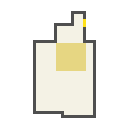

In [80]:
Image[0]

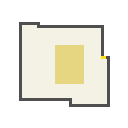

In [79]:
Image[1]